# Análises descritivas do preço total

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys

sys.path.append("../../odbc/")
from query_tools import run_query, get_table


## Funções úteis

### Variabilidade geral do preço

In [3]:
def variabilidade(column, from_table):
    query = f"""
        SELECT "legId",
                stddev("{column}") AS standard_deviation,
                variance("{column}") AS variance,
                max("{column}") AS max,
                min("{column}") AS min,
                max("{column}") -  min("{column}") AS amplitude,
                AVG("{column}") AS average,
                count(*) AS number_lines
        FROM {from_table}
        GROUP BY "legId"
    """
    return run_query(query)

In [4]:
def plot_multiplos_boxplots(df):
    for column in df.select_dtypes(include=['float64', 'int64']):
        plt.figure(figsize=(6, 4))
        df.boxplot(column=column)
        plt.title(f'Boxplot - {column}')
        plt.show()
    return 

In [5]:
def variabilidade_por_dia(column, from_table):
    query = f"""
        SELECT  DATE_TRUNC('day', S."operationalSearchTime") AS search_day,
                T."legId",
                stddev(T."{column}") AS standard_deviation,
                variance(T."{column}") AS variance,
                max(T."{column}") AS max,
                min(T."{column}") AS min,
                max(T."{column}") - min("{column}") AS amplitude,
                AVG(T."{column}") AS average,
                count(*) AS number_lines
        FROM {from_table} T
        JOIN (
            SELECT FS."searchId" , FS."operationalSearchTime"
            FROM flight.search FS
        ) S ON T."searchId" = S."searchId"
        GROUP BY search_day, T."legId"
    """
    return run_query(query)

### Dias até a viagem

In [6]:
def get_normalized_fares_and_search():
    query = """
        SELECT S."searchId", NF."legId", S."operationalSearchTime",
            S."flightDay", NF."totalFare", NF."normalizedTotalFare",
            DATE_PART('day', S."flightDay" - S."operationalSearchTime") AS "daysUntilFlight"
        FROM flight.normalized_fares_view NF
        JOIN (
            SELECT FS."searchId", FS."operationalSearchTime",
                FS."flightDay"
            FROM flight.search FS
        ) S ON S."searchId" = NF."searchId"
    """
    normalized_fares_and_search = run_query(query)
    return normalized_fares_and_search

In [7]:
def plot_serie_preco_passagem(df, n_passagens=1, legId_list=None, seed=12_01_2001,
                              y_column="totalFare", mostra_defeitos_na_coleta=True):
    time_column = 'operationalSearchTime'

    if legId_list is None:
        rd.seed(seed)
        legId_list = df["legId"].unique().tolist()
        legId_list = rd.sample(legId_list, n_passagens)

    for legId in legId_list:
        df_voo = df.query(f"legId == '{legId}' ")
        df_voo = df_voo.sort_values(time_column)

        start_date = df_voo[time_column].min()
        end_date = df_voo[time_column].max()

        if mostra_defeitos_na_coleta:
            date_range = pd.date_range(start=start_date, end=end_date, freq='H')
            complete_df = pd.DataFrame({time_column: date_range})

            coleta_completa = pd.merge(complete_df, df_voo, on=time_column, how='left')    
            coleta_completa[y_column] = coleta_completa[y_column].fillna(0)

            x = coleta_completa[time_column]
            y = coleta_completa[y_column]

        else:
            x = df_voo[time_column]
            y = df_voo[y_column]

        # Constroi o gráfico
        plt.figure(figsize=(15, 5))
        plt.plot(x, y)
        plt.xticks(rotation=90)

        # Configurando as datas no eixo x
        num_ticks = 60  # Número desejado de ticks no eixo x
        date_range = pd.date_range(start=start_date, end=end_date, periods=num_ticks)
        plt.xticks(date_range, rotation=90)

        plt.xlabel('Data e Hora')
        plt.ylabel(y_column)
        plt.title(f'Preço do voo {legId}')
        plt.show()

    return legId_list

## Variabilidade geral do preço

### Como é a variabilidade do preço de um voo?

In [8]:
column = "totalFare"
from_table = "flight.fare"

variability_totalFare = variabilidade(column, from_table)

In [20]:
# variability_totalFare.to_parquet("variability_totalFare.parquet")

NameError: name 'variability_totalFare' is not defined

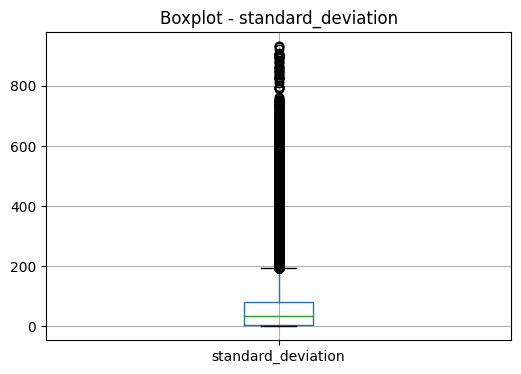

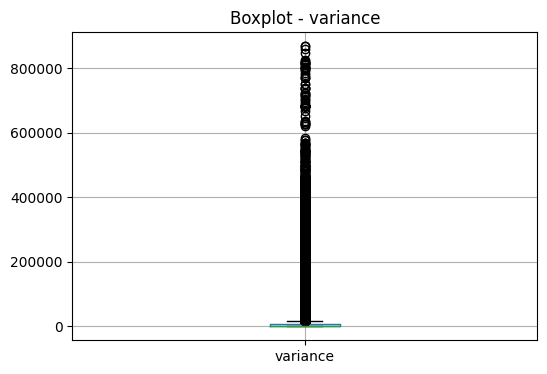

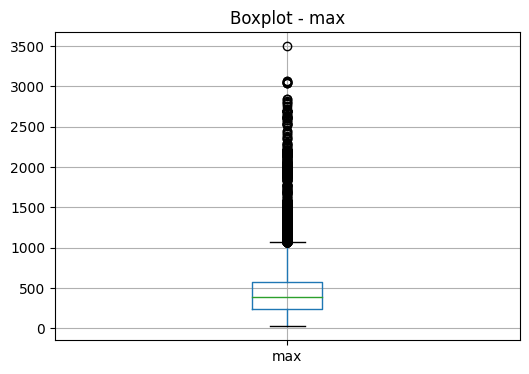

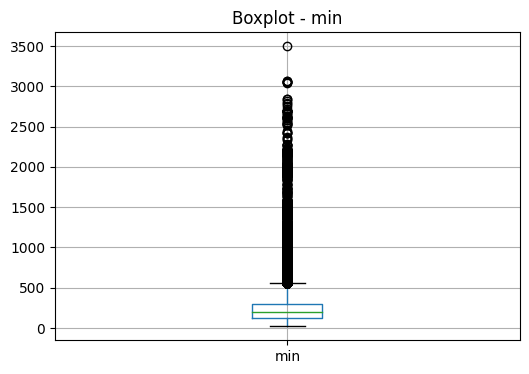

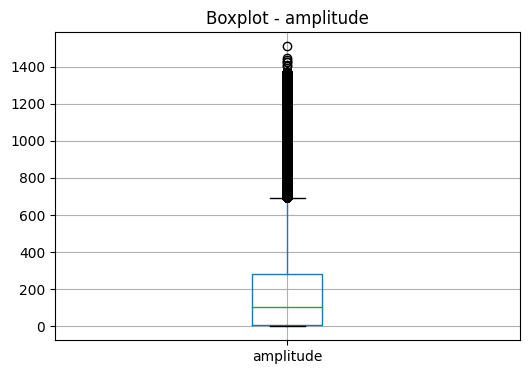

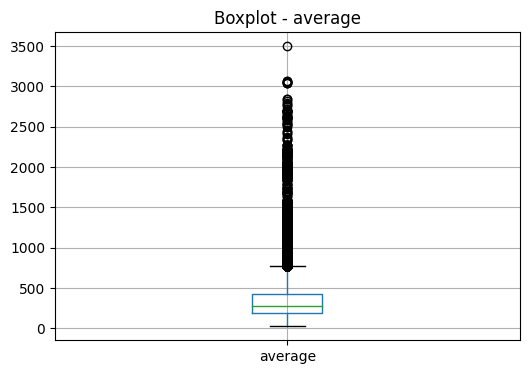

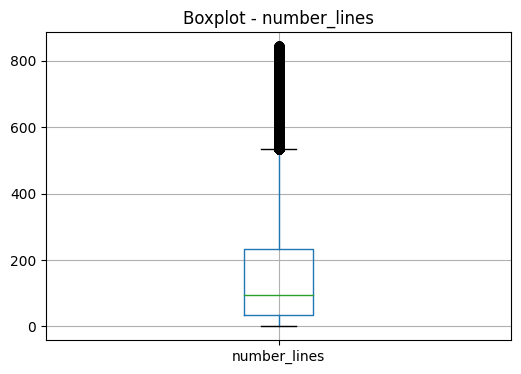

In [9]:
plot_multiplos_boxplots(variability_totalFare)
del variability_totalFare

### Como é a variabilidade do preço de um voo normalizado pelo trecho?

In [13]:
column = "normalizedTotalFare"
from_table = "flight.normalized_fares_view"
variabilidade_totalFare_normalizado = variabilidade(column, from_table)

In [ ]:
# variabilidade_totalFare_normalizado.to_parquet("variabilidade_totalFare_normalizado.parquet")

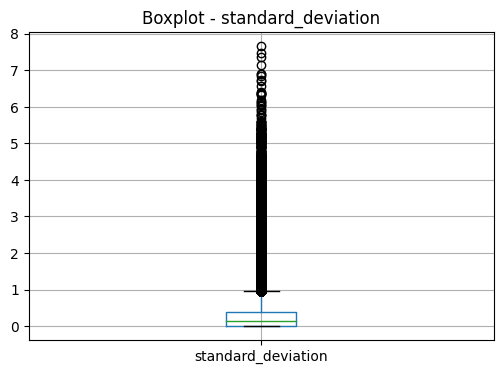

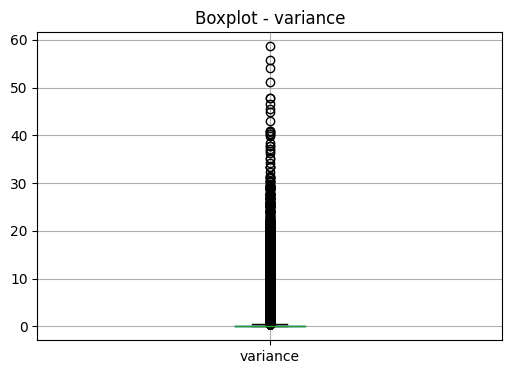

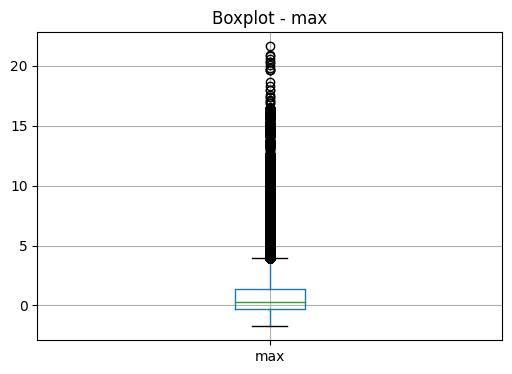

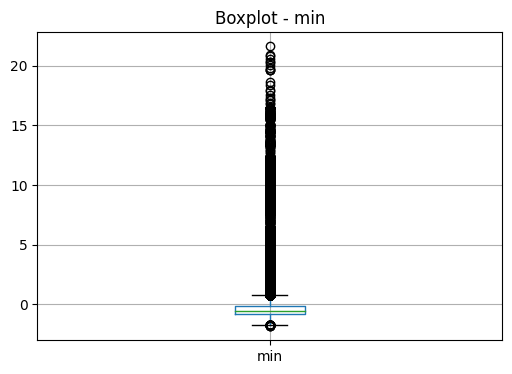

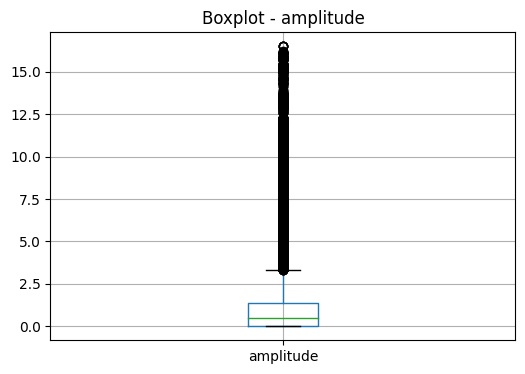

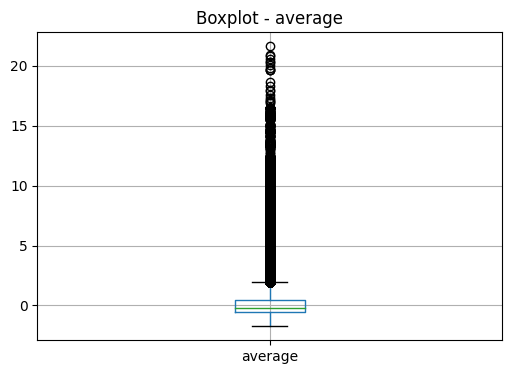

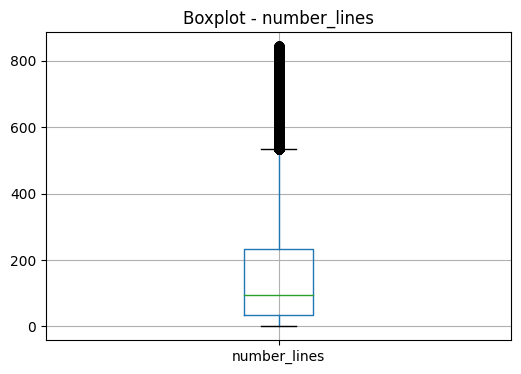

In [14]:
plot_multiplos_boxplots(variabilidade_totalFare_normalizado)

### Como é a variabilidade do preço de um voo ao longo do dia?

In [15]:
column = "totalFare"
from_table = "flight.fare"

variability_dayly_totalFare = variabilidade_por_dia(column, from_table)

In [16]:
variability_dayly_totalFare.tail(1)

,search_day,legId,standard_deviation,variance,max,min,amplitude,average,number_lines
14740159,2023-06-18,ffffe1e4a367b8d79b4ce1ecc1c558eb,0.0,0.0,294.9,294.9,0.0,294.9,23


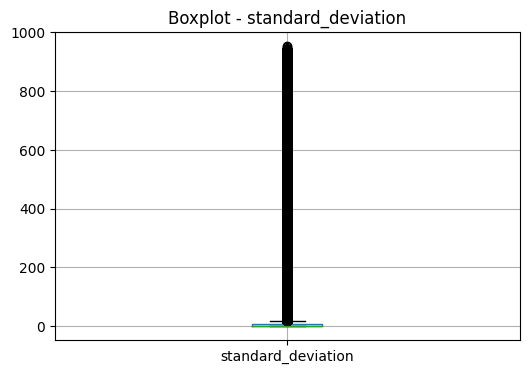

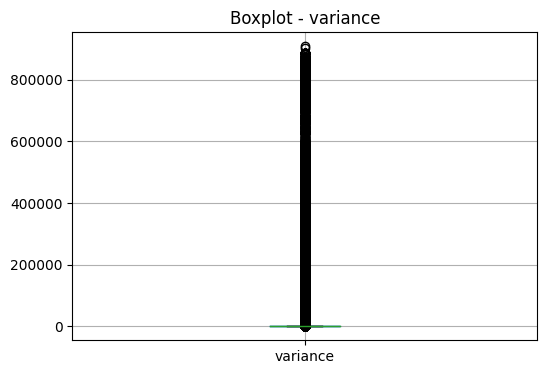

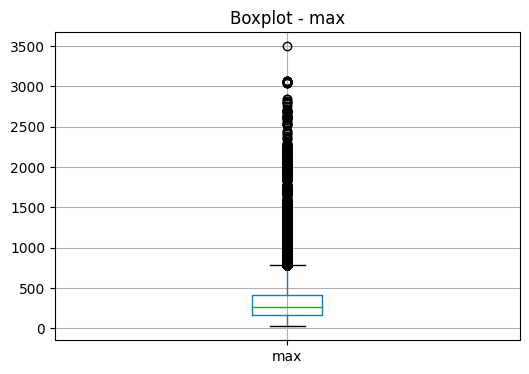

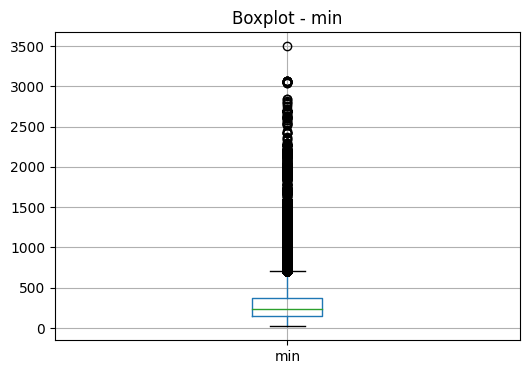

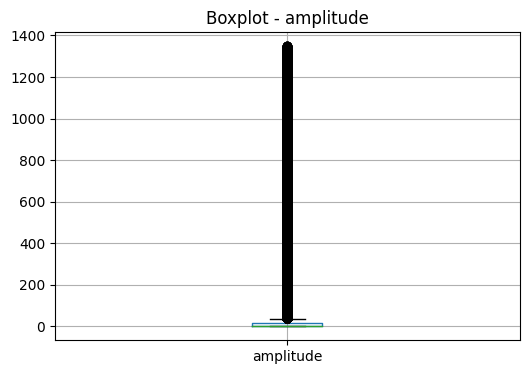

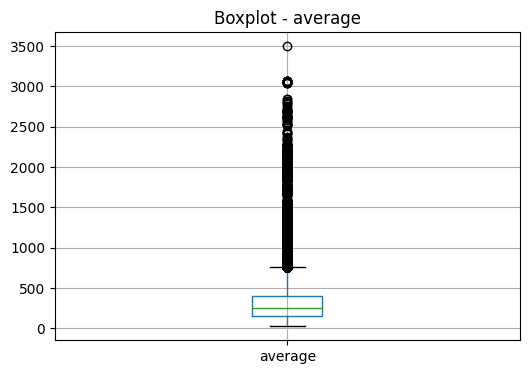

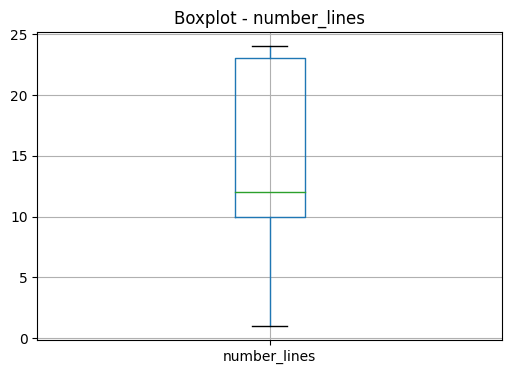

In [17]:
plot_multiplos_boxplots(variability_dayly_totalFare)
del variability_dayly_totalFare

### Como é a variabilidade do preço de um voo normalizado ao longo do dia?


In [18]:
column = "normalizedTotalFare"
from_table = "flight.normalized_fares_view"

variability_dayly_normalizedTotalFare = variabilidade_por_dia(column, from_table)

IOStream.flush timed out


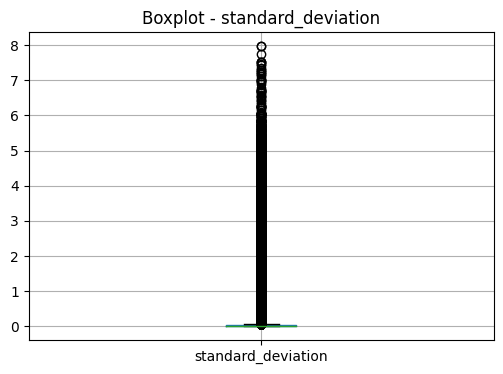

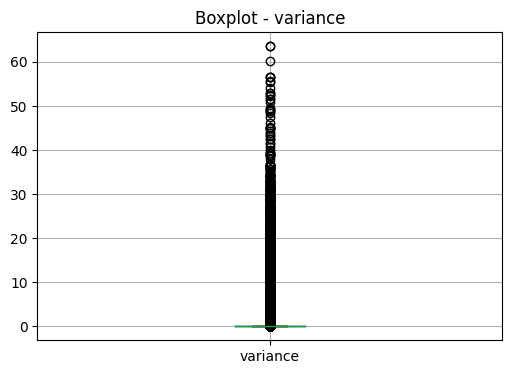

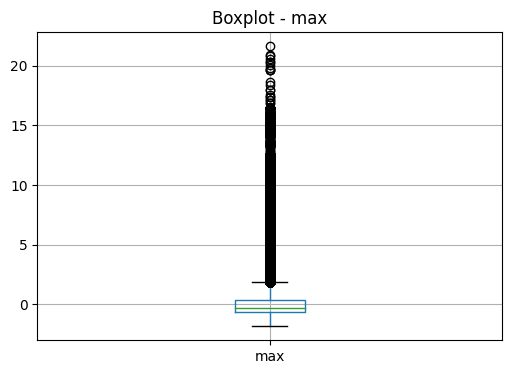

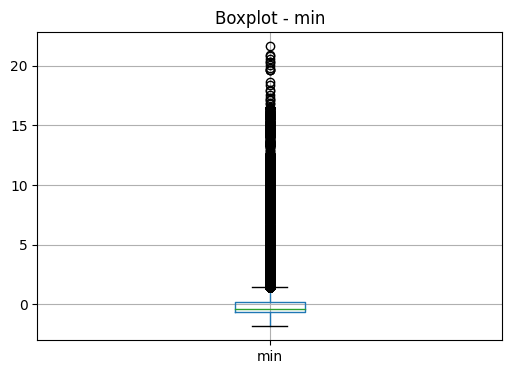

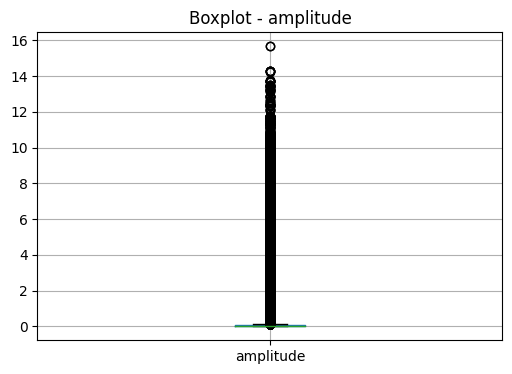

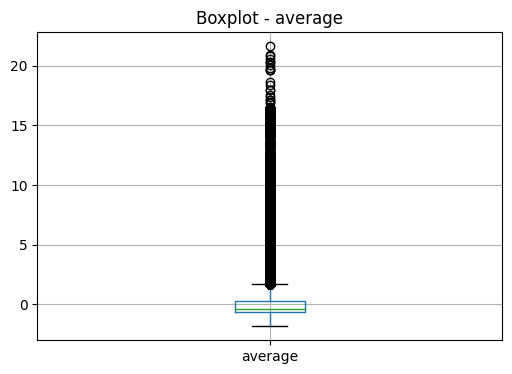

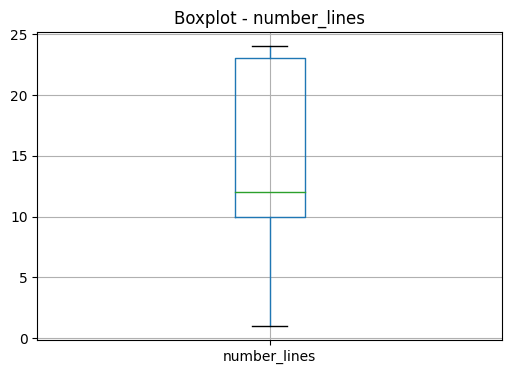

In [19]:
plot_multiplos_boxplots(variability_dayly_normalizedTotalFare)
del variability_dayly_normalizedTotalFare

## Dado de preço normalizado

In [ ]:
normalized_fares_and_search = get_normalized_fares_and_search()
normalized_fares_and_search.shape

In [ ]:
normalized_fares_and_search.to_parquet("normalized_fares_and_search_prod.parquet")

In [ ]:
normalized_fares_and_search.head(2)

## Dias até a viagem

### Correlação entre dias até a viagem e o preço normalizado

In [ ]:
# normalized_fares_and_search = pd.read_parquet("normalized_fares_and_search_prod.parquet")

In [ ]:
pearson_corr, p_value = stats.pearsonr(normalized_fares_and_search["normalizedTotalFare"], normalized_fares_and_search["daysUntilFlight"])

print("Correlação de Pearson:", pearson_corr)
print("P-value:", p_value)
# FALTA VERIFICAR OS PRESSUPOSTOS DO TESTE

In [ ]:
pearson_corr, p_value = stats.pearsonr(normalized_fares_and_search["totalFare"], normalized_fares_and_search["daysUntilFlight"])

print("Correlação de Pearson:", pearson_corr)
print("P-value:", p_value)
# FALTA VERIFICAR OS PRESSUPOSTOS DO TESTE

### Otimiza a memoria

In [ ]:
dias = [7,30, 50]
normalized_fares_and_search_filtred = normalized_fares_and_search[normalized_fares_and_search.daysUntilFlight.isin(dias)]

In [ ]:
del normalized_fares_and_search

### Exemplos do preço da passagem ao longo do tempo.

In [ ]:
n_passagens = 3

In [ ]:
plot_serie_preco_passagem(normalized_fares_and_search_filtred, n_passagens=n_passagens)

In [ ]:
plot_serie_preco_passagem(normalized_fares_and_search_filtred, n_passagens=n_passagens, mostra_defeitos_na_coleta=False)

In [ ]:
plot_serie_preco_passagem(normalized_fares_and_search_filtred, n_passagens=n_passagens, mostra_defeitos_na_coleta=False, y_column="normalizedTotalFare")

### Existe diferença de preço por dias até a viagem?

In [ ]:
# Criar o boxplot lado a lado
plt.figure(figsize=(15, 5))
normalized_fares_and_search_filtred.boxplot(column="normalizedTotalFare", by="daysUntilFlight", widths=0.4)

# Configurar o título e rótulos dos eixos
# plt.title("Boxplot de normalizedTotalFare por daysUntilFlight")
plt.xlabel("Dias até a viagem")
plt.ylabel("Preço da passagem normalizado")

# Exibir o gráfico
plt.show()


In [ ]:
# Criar o boxplot lado a lado
plt.figure(figsize=(10, 6))
normalized_fares_and_search_filtred.query("normalizedTotalFare <= 3").boxplot(column="normalizedTotalFare", by="daysUntilFlight", widths=0.4)

# Configurar o título e rótulos dos eixos
plt.xlabel("Dias até a viagem")
plt.ylabel("Preço da passagem normalizado")

# Exibir o gráfico
plt.show()


### Cruzamento: preço e dias até a viagem
FIZ, MAS NÃO DÁ PARA VER/ENTENDER NADA


In [ ]:
# # Extrair as colunas do dataframe
# normalized_total_fare = normalized_fares_and_search['normalizedTotalFare']
# days_until_flight = normalized_fares_and_search['daysUntilFlight']

# # Criar o scatter plot
# plt.scatter(days_until_flight, normalized_total_fare)
# plt.xlabel('Days Until Flight')
# plt.ylabel('Normalized Total Fare')
# plt.title('Scatter Plot: Normalized Total Fare vs. Days Until Flight')

# # Exibir o gráfico
# plt.show()


## Turno do dia